In [253]:
import numpy as np
import pymc3 as pm 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import theano
from theano import tensor as tt

sns.set_style("ticks")

font = { 'family' : 'Arial',
         'weight' : 'normal',
        'size'    : 17}
plt.rc('font', **font)

In [254]:
"""
Random Seed for each model 
"""

SEED = np.random.seed(1994)

In [255]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [256]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3
    

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [257]:
"""
Muscovite 1 

"""

age_m1 = 71.85e6 
age1_err = 0.39e6

In [258]:
"""
Muscovite 2
"""

age_m2 = 148.85e6
age2_err = 0.79e6

In [259]:
age_input = np.array([age_m1, 
                     age_m2])
age_err_input = np.array([age1_err, 
                         age2_err])

In [260]:
"""
Create Age Spectra
"""

'\nCreate Age Spectra\n'

12.889770434773263

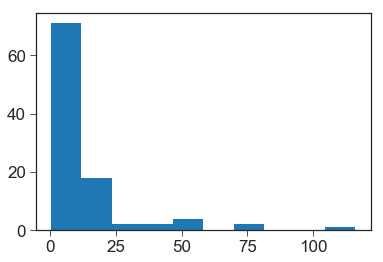

In [262]:
z = np.random.lognormal(2, 1, 100)
plt.hist(z)
z.mean()

In [263]:
# Experiemental 
temp = np.array([725, 775, 820, 850, 875, 900, 915, 930, 
                945, 960, 980, 1000, 1030, 1100, 1400, 1500, 1600, 1650, 1800]) + 273.15
time = 12*60*np.ones(len(temp))

In [264]:
def age_spectra2(samples): 
    age = []
    frel = []
    for i in range(samples): 
        age1 = np.random.normal(74, 0.39)
        age2 = np.random.normal(148, 0.78)
        
        ea1 = 260
        ea2 = 260
        
        d01 = 2
        d02 = 2

        
        a1 = np.random.uniform(0.0177/2, 0.0250/2)
        a2 = np.random.uniform(0.0177/2, 0.0250/2)
        
        c1 = Increment(ea1, d01, a1,
                       temp, time).eval()
        c2 = Increment(ea2, d01, a2,
                       temp, time).eval()
        
        Q = 0.25*c1 + 0.75*c2 
        
        f1 = fracrelx(ea1, d01, a1, 
                 temp, time).eval()
        
        f2 = fracrelx(ea2, d02, a2, 
                 temp, time).eval()
        
        f_rel = 0.25*f1 + 0.75*f2
        

        frel.append(f_rel)
        
        # Telegraph peak Age Spectra
        age_m = 0.25*(c1*age1)/Q + 0.75*(c2*age2)/Q 
        age.append(age_m)
    return np.array(age), np.array(frel)

In [265]:
age, frel = age_spectra2(10)

In [266]:
print(age[-1000:].mean(axis = 0), frel.mean(axis = 0))

[129.79753824 129.79753824 129.79753824 129.79753824 129.79753824
 129.79753824 129.79753824 129.79753824 129.79753824 129.79753824
 129.79753824 129.79753824 129.79753824 129.78380396 129.49319373
 127.20750545 120.58743365 117.35101434 110.36160719] [0.00185342 0.00391305 0.00723132 0.0105961  0.01434816 0.01917941
 0.0226941  0.02674043 0.03138115 0.03668417 0.04491242 0.05463777
 0.07249091 0.12891319 0.75399068 0.95092921 0.9986754  0.99993737
 1.        ]


In [267]:
data_age = age[-1000:].mean(axis = 0)

data_age = data_age.reshape(len(temp))

data_age

array([129.79753824, 129.79753824, 129.79753824, 129.79753824,
       129.79753824, 129.79753824, 129.79753824, 129.79753824,
       129.79753824, 129.79753824, 129.79753824, 129.79753824,
       129.79753824, 129.78380396, 129.49319373, 127.20750545,
       120.58743365, 117.35101434, 110.36160719])

In [268]:
frel_data = frel.mean(axis = 0)
frel_data = frel_data.reshape(len(temp))
frel_data

array([0.00185342, 0.00391305, 0.00723132, 0.0105961 , 0.01434816,
       0.01917941, 0.0226941 , 0.02674043, 0.03138115, 0.03668417,
       0.04491242, 0.05463777, 0.07249091, 0.12891319, 0.75399068,
       0.95092921, 0.9986754 , 0.99993737, 1.        ])

In [269]:
low, high = np.percentile(age[-100:], [2.5, 97.5], axis = 0)
frel_low, frel_high = np.percentile(frel, [30, 70.5], axis = 0)

In [270]:
"""
Plotting Parameters
"""

frel_plot = np.insert(frel.mean(axis = 0),0,0)
age_plot = np.insert(age.mean(axis = 0), 0, age.mean(axis = 0)[0])
age_low = np.insert(low, 0, low[0])
age_high = np.insert(high, 0, high[0])

In [271]:
import os 
cwd = os.chdir('/Users/jackcarter/Downloads')
df_kula = pd.read_csv('Kula_Muscovite_1_data.csv')

In [272]:
df_kula.head()

,temp1,time1,ar391,ar401,age1,age_err1
0,725,12,92.06,6137.52,121.86,0.75
1,775,12,74.49,3128.33,131.81,0.61
2,820,12,185.53,7118.49,129.69,0.58
3,850,12,327.39,11860.89,127.00,0.57
4,875,12,487.57,18061.60,131.10,0.58


In [273]:
def cumsum(x): 
    y = np.cumsum(x)
    z = y/y[-1]
    return z

In [274]:
cum_data = cumsum(df_kula['ar391'].values)

In [275]:
"""
Kula Plot
"""
frel_k_plot = np.insert(cum_data, 0, 0)
k_age_plot = np.insert(df_kula['age1'].values,
                       0,
                       df_kula['age1'].values[0])
k_err_plot = np.insert(df_kula['age_err1'].values,
                       0 ,
                       df_kula['age_err1'].values[0])

In [276]:
sns.set_style("ticks")

font = { 'family' : 'Arial',
         'weight' : 'normal',
        'size'    : 17}
plt.rc('font', **font)

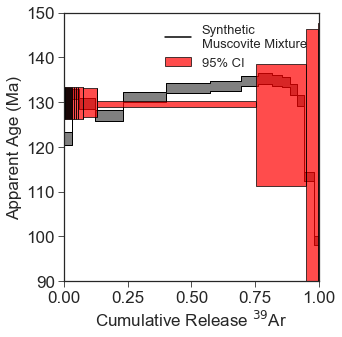

In [277]:
plt.figure(figsize = (5,5 ))
plt.fill_between(frel_k_plot, 
                k_age_plot - 2*k_err_plot, 
                k_age_plot + 2*k_err_plot, 
                facecolor = 'grey', 
                edgecolor = 'k', 
                step = 'pre')
plt.plot(frel_plot, age_plot/1e6, 
        label = 'Synthetic\nMuscovite Mixture', 
        color = 'k', 
        drawstyle = 'steps')
plt.fill_between(frel_plot, age_low, age_high, 
                facecolor = 'r', 
                edgecolor = 'k', 
                step = 'pre', 
                label = '95% CI', alpha = 0.7)

for i in range(len(temp)): 
    plt.vlines(frel_plot[i], age_low[i], age_high[i], color = 'k', 
              lw = 0.9)
    
    
for i in range(len(cum_data)): 
    plt.vlines(frel_k_plot[i], k_age_plot[i] - 2*k_err_plot[i],
               k_age_plot[i] - 2*k_err_plot[i],
               color = 'k', 
               lw = 1)
    
plt.ylim(90, 150)
plt.xlim(0,1)
plt.ylabel('Apparent Age (Ma)')
plt.xlabel('Cumulative Release $^{39}$Ar')
plt.legend(fontsize = (13))
plt.tight_layout()
plt.savefig('data_model_kula_mix1.pdf')

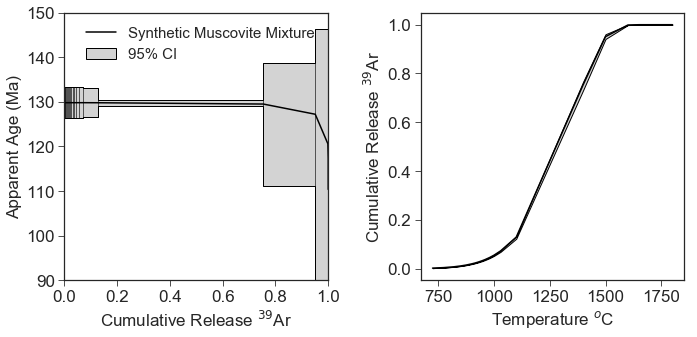

In [320]:
sns.set_style("ticks")

font = { 'family' : 'Arial',
         'weight' : 'normal',
        'size'    : 17}
plt.rc('font', **font)

fig, ax = plt.subplots(1,2, figsize = (10, 5))
ax[0].plot(frel_plot, age_plot, 
        label = 'Synthetic Muscovite Mixture', 
        color = 'k')
ax[0].fill_between(frel_plot, age_low, age_high, 
                facecolor = 'lightgrey', 
                edgecolor = 'k', 
                step = 'pre', 
                label = '95% CI')
ax[0].set_ylim(110, 140)
ax[0].set_xlim(0,1)
ax[0].set_ylabel('Apparent Age (Ma)')
ax[0].set_xlabel('Cumulative Release $^{39}$Ar')
ax[0].legend(fontsize = (15))


for i in range(len(temp)): 
    ax[0].vlines(frel_plot[i], age_low[i], age_high[i], color = 'k', 
              lw = 0.6)


ax[1].plot(temp-273.15, frel.mean(axis = 0), 
          color = 'k')
ax[1].fill_between(temp-273.15, frel_low, frel_high, 
                  facecolor = 'lightgrey', 
                  edgecolor = 'k')
ax[1].set_xlabel('Temperature $^{o}$C')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[0].set_ylim(90, 150)
plt.tight_layout()
plt.savefig('Modelled_muscovite_test.pdf')

In [279]:
from theano import shared
data_err = high - low
s_data_err = shared(data_err)

1.6572263749970153

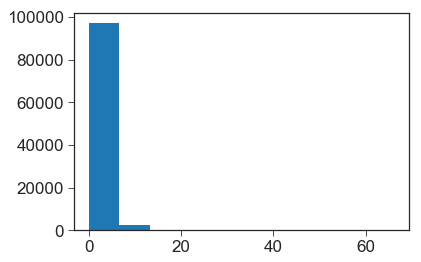

In [281]:
x = np.random.lognormal(0, 1, 100000)
plt.hist(x)
x.mean()

In [300]:
M_test = pm.Model()
N = data_age.shape[0]
with M_test: 
    
    """
    Mixing Fraction
    """
    
    phi = pm.Dirichlet('phi', np.array([1, 1]), 
                      shape = 2)
    
    w1 = phi[0]
    w2 = phi[1]
    
    ea1 = pm.Normal('ea1', mu = 260, sd = 10)
    ea2 = pm.Normal('ea2', mu = 260, sd = 10)
    
    
    d01 = pm.Lognormal('d01', 0, 1)
    d02 = pm.Lognormal('d02', 0, 1)
    
    
    a1 = pm.Uniform('a1', 0.0177/2, 0.0250/2)
    a2 = pm.Uniform('a2', 0.0177/2, 0.0250/2)

    

In [301]:
with M_test: 
    age1 = pm.HalfNormal('age1',sd = 500)
    
    age2 = pm.HalfNormal('age2',sd = 500,
                     testval = 100)


In [302]:
with M_test: 
    f1 = fracrelx(ea1, d01,
                 a1, temp, time)
    
    f2 = fracrelx(ea2, d02,
                 a2, temp, time)
    
    frel_model = w1*f1  + w2*f2

In [303]:
with M_test: 
    
    f_err = pm.HalfNormal('f_err', 
                         sd = 0.05, 
                         shape = N)
    
    obs1 = pm.Normal('obs1', mu = frel_model, 
                    sd = f_err, observed = frel_data)

In [304]:
with M_test: 
    c1 = Increment(ea1, d01,
                 a1, temp, time)
    
    c2 = Increment(ea2, d02,
                 a2, temp, time)
    
    q = w1*c1 + w2*c2
    
    age_model = age1*w1*c1/q + age2*w2*c2/q

In [305]:
with M_test: 
    
    age_err = pm.HalfNormal('age_err', 
                           sd = 20, 
                           shape = N)
    
    obs2 = pm.Normal('obs2', mu = age_model, 
                    sd = age_err, 
                    observed = data_age)

In [306]:
M_test.check_test_point()

a1_interval__           -1.39
a2_interval__           -1.39
age1_log__              -0.77
age2_log__              -1.86
age_err_log__          -14.63
d01_log__               -0.92
d02_log__               -0.92
ea1                     -3.22
ea2                     -3.22
f_err_log__            -14.63
obs1                    31.86
obs2                  -626.29
phi_stickbreaking__     -1.39
Name: Log-probability of test_point, dtype: float64

In [307]:
SAMPLES = 50000
BURN = 10000
SEED = np.random.seed(1248)


with M_test: 
    step1 = pm.Metropolis([age1, age2])
    step2 = pm.Metropolis([age_err, f_err, 
                          a2, a1, d01, d02, 
                          ea1, ea2, phi])
    trace = pm.sample(SAMPLES, tune = BURN, 
                      step = [step1, step2])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [age2]
>>Metropolis: [age1]
>CompoundStep
>>Metropolis: [phi]
>>Metropolis: [ea2]
>>Metropolis: [ea1]
>>Metropolis: [d02]
>>Metropolis: [d01]
>>Metropolis: [a1]
>>Metropolis: [a2]
>>Metropolis: [f_err]
>>Metropolis: [age_err]
Sampling 2 chains: 100%|██████████| 120000/120000 [11:58<00:00, 167.11draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


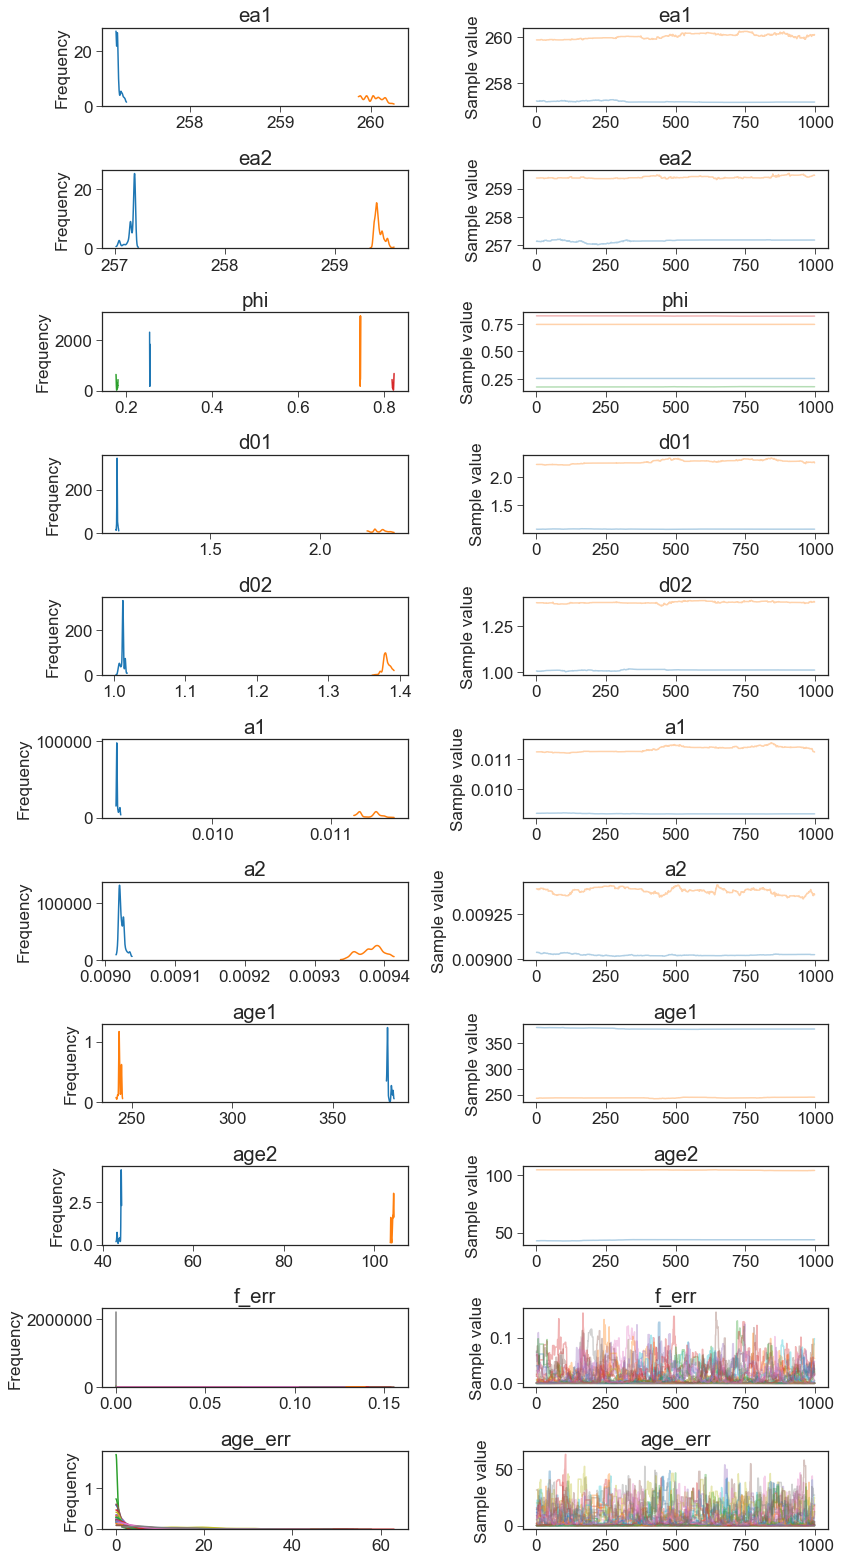

In [308]:
pm.traceplot(trace[-1000:]); 

In [309]:
with M_test: 
    ppc = pm.sample_ppc(trace[-10000:], 10000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 10000/10000 [02:01<00:00, 82.12it/s]


In [310]:
ppc_age = ppc['obs2'].mean(axis = 0)
low_age, high_age = np.percentile(ppc['obs2'], 
                                 [2.5, 97.5], axis = 0)

ppc_frel = ppc['obs1'].mean(axis = 0)

In [311]:
"""
Posterior Plotting 
"""
age_post_plot = np.insert(ppc_age, 0, ppc_age[0])
age_low_plot = np.insert(low_age, 0, low_age[0])
age_high_plot = np.insert(high_age, 0, high_age[0])

ppc_frel_plot = np.insert(ppc_frel, 0, 0)

low_frel_plot, high_frel_plot = np.percentile(ppc['obs1'], [2.5, 
                                                           97.5], 
                                             axis = 0)

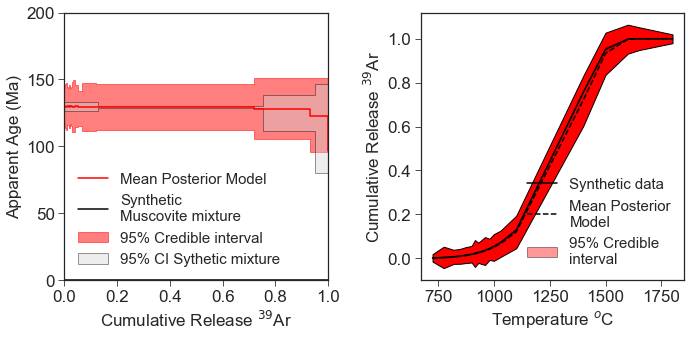

In [312]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))

ax[0].plot(ppc_frel_plot, age_post_plot, 
        label = 'Mean Posterior Model', 
        color = 'r', 
          drawstyle = 'steps')


ax[0].fill_between(ppc_frel_plot, age_low_plot, 
                  age_high_plot, color = 'r', 
                  step = 'pre', 
                  alpha = 0.5, 
                  edgecolor = 'k', 
                  label = '95% Credible interval')



ax[1].plot(temp-273.15, ppc_frel, 
          color = 'r')
ax[1].fill_between(temp-273.15, low_frel_plot, high_frel_plot, 
                  facecolor = 'r', 
                  edgecolor = 'k')
ax[1].set_xlabel('Temperature $^{o}$C')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')


ax[0].plot(frel_plot, age_plot/1e6, 
        label = 'Synthetic\nMuscovite mixture', 
        color = 'k', 
          drawstyle = 'steps')
ax[0].fill_between(frel_plot, age_low, age_high, 
                facecolor = 'lightgrey', 
                edgecolor = 'k', 
                step = 'pre', 
                label = '95% CI Sythetic mixture', 
                  alpha = 0.4)
ax[0].legend(fontsize = (15))


ax[1].plot(temp-273.15, frel.mean(axis = 0), 
          color = 'k',
          label = 'Synthetic data')
ax[1].plot(temp-273.15, ppc_frel, 
          color = 'k', ls =  '--', 
          label = 'Mean Posterior\nModel')
ax[1].fill_between(temp-273.15, frel_low, frel_high, 
                  facecolor = 'r', 
                  edgecolor = 'k', 
                  alpha = 0.4, 
                  label = '95% Credible\ninterval')

ax[0].set_ylabel('Apparent Age (Ma)')
ax[0].set_xlabel('Cumulative Release $^{39}$Ar')
ax[0].set_ylim(0, 200)
ax[0].set_xlim(0,1)
ax[1].legend(fontsize =15)

plt.tight_layout()
plt.savefig('Muscovite_test_case_model_out.pdf')

In [313]:
trace['age1'][-10000:].mean(axis = 0)

243.33824230734493

In [314]:
trace['age2'][-10000:].mean(axis = 0)

103.84725579803262

In [315]:
trace['age1'][-10000:].std(axis = 0)

0.8588092517138213

In [317]:
trace['age2'][-10000:].std(axis = 0)

0.2699662507194736

In [316]:
np.percentile(trace['age2'][-10000:], [2.5, 97], axis = 0) - trace['age2'][-10000:].mean(axis = 0)

array([-0.32947511,  0.57367805])

In [318]:
z = np.array([trace['age2'][-10000:].mean(axis = 0), 
             trace['age1'][-10000:].mean(axis = 0)])
z_err = np.array([trace['age2'][-10000:].std(axis = 0),
                 trace['age1'][-10000:].std(axis = 0)])

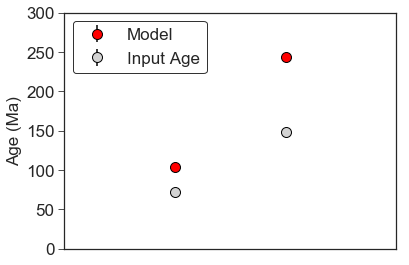

In [319]:
plt.errorbar(np.linspace(1, 2, 2),z, fmt = 'o',
            yerr = z_err, markersize = 10, 
            markerfacecolor = 'r', 
            markeredgecolor = 'k', color = 'k', 
            label = 'Model')


plt.errorbar(np.linspace(1, 2, 2),age_input/1e6, fmt = 'o',
            yerr = age_err_input/1e6, markersize = 10, 
            markerfacecolor = 'lightgrey', 
            markeredgecolor = 'k', color = 'k', 
            label = 'Input Age')

legend = plt.legend(frameon = True, loc = 'best')

legend.get_frame().set_edgecolor('k')
plt.xlim(0, 3)
plt.ylim(0, 300)
plt.xticks([])
plt.ylabel('Age (Ma)')
plt.tight_layout()
plt.savefig('muscovite_model_comparison.pdf')